In [5]:
import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from scripts import aesthetics
from sklearn import decomposition, preprocessing

from scripts import helper

aesthetics.activate_paper_rcParams()

pd.set_option("display.max_columns", 1000)

%load_ext autoreload
%autoreload 2

# Neuroblastoma Preprocess RNA

In this notebook, we'll process the GMKF RNA for neuroblastoma and take a look at some QC metrics.

# Load our samples and reference gene lists

In [6]:
# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.4.cohort_metadata.w_control_assignments.tsv.gz"
samples_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.4.final_analysis_cohort.samples.list"

In [7]:
# list of genes that are annotated - drop ensembl IDs
gene_ref = pd.read_csv(
    "data/gencode_hg38_protein_coding_genes_for_annotation.txt"
)
gene_ref = gene_ref[~gene_ref["value"].str.startswith("ENSG00")]
gene_ref = gene_ref["value"].tolist()

Load metadata and SVs

In [8]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

# Read in our RNA data for GMKF

Load our TPMs. We'll briefly take a look at the manifest file first.

In [9]:
gmkf_manifest = pd.read_csv(
    "data/gmkf-expression/GMKF_neuroblastoma_transcriptomic_data_manifest_rsem_gene_files_2_22_22.txt",
    sep="\t",
)
gmkf_manifest = gmkf_manifest.dropna(subset=gmkf_manifest.columns, how="all")
gmkf_manifest.head(2)

,id,name,file_name_simplified,size,project,ethnicity,gender,race,vital_status,sample_id,sample_type,platform,age_at_diagnosis,tumor_location,aliquot_id,library_id,histology,composition,reference_genome,species,case_id,data_type,investigation,experimental_strategy
0,62140522c087b02cb6535584,4452cf2b-df37-439b-92d0-7e3853c50eee.rsem.gene...,4452cf2b-df37-439b-92d0-7e3853c50eee,2503209.0,rgillani/gmkf-neuroblastoma-transcriptomic-data,Not Hispanic or Latino,Female,Reported Unknown,Alive,BS_5W25GMQ1,Tumor,Illumina,1295.0,Reported Unknown,575765.0,GMKF-30-PATMDE03-01B-99R,"Ganglioneuroblastoma, intermixed",Solid Tissue,GRCh38,Homo sapiens,PT_4A1B95TK,Gene Expression,Discovering the Genetic Basis of Human Neurobl...,RNA-Seq
1,62140522c087b02cb6535578,7e31540e-112f-439a-9562-ad760bb6d5c5.rsem.gene...,7e31540e-112f-439a-9562-ad760bb6d5c5,2488632.0,rgillani/gmkf-neuroblastoma-transcriptomic-data,Not Hispanic or Latino,Male,White,Alive,BS_5Y7PNW71,Tumor,Illumina,1712.0,Reported Unknown,575872.0,GMKF-30-PAVKZC03-01A-01R,"Ganglioneuroblastoma, nodular",Solid Tissue,GRCh38,Homo sapiens,PT_GSWXPFPQ,Gene Expression,Discovering the Genetic Basis of Human Neurobl...,RNA-Seq


In [10]:
gmkf_manifest.shape

(209, 24)

This gives us a way to map file names to sample names.

In [11]:
file_to_sample = dict(zip(gmkf_manifest["name"], gmkf_manifest["case_id"]))

In [12]:
gmkf_tpms = []
gmkf_counts = []

# loop through the RSEM files, read them in, and find the sample name
for file in glob.glob(
    "data/gmkf-expression/*.rsem.genes.tsv"
):
    file_name = file.split("/")[-1][:-3] + "results.gz"

    sample = file_to_sample[file_name]

    data = pd.read_csv(file, sep="\t")
    data["sample"] = sample
    
    # get the TPMs
    gmkf_tpms.append(data[["sample", "gene_id", "TPM"]])
    
    # we keep counts for filtering later
    gmkf_counts.append(data[['sample', 'gene_id', 'expected_count']])

gmkf_tpms = pd.concat(gmkf_tpms)
gmkf_counts = pd.concat(gmkf_counts)

# transform to a tpm matrix
gmkf_tpms = gmkf_tpms.pivot(
    index="gene_id", columns="sample", values="TPM"
).reset_index()

# transform to a tpm matrix
gmkf_counts = gmkf_counts.pivot(
    index="gene_id", columns="sample", values="expected_count"
).reset_index()

# add gene info to these matrices
for d in [gmkf_tpms, gmkf_counts]:
    d.insert(1, "ENSEMBL_ID", d["gene_id"].apply(lambda x: x.split(".")[0]))
    d.insert(2, "gene_symbol", d["gene_id"].apply(lambda x: x.split("_")[-1]))

In [13]:
gmkf_tpms.head(6)

sample,gene_id,ENSEMBL_ID,gene_symbol,PT_02SNWVRF,PT_0XAWD5CE,PT_10KTTTPD,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1MWZEHCT,PT_1NDSW1JX,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_1YAJEAMJ,PT_21PJ8R0Z,PT_22BQQFYM,PT_26E4RFYV,PT_2AZNEYG9,PT_2DX56CE0,PT_2FB9C15K,PT_2G290D0G,PT_2HCWZNTR,PT_2JZNQGTR,PT_2M970JK9,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_2YBKT6RW,PT_3VNMNFT6,PT_3WF5J3PZ,PT_3YW2V4JK,PT_49FZV0HC,PT_4A1B95TK,PT_4FTZAAC4,PT_4W8PD8TR,PT_4WVGKQRX,PT_4Y3P2N1P,PT_53M7K3JE,PT_56ZM694R,PT_581CW7RN,PT_58J0PB4V,PT_5CPS8GNT,PT_5E269C8Z,PT_5FCYBT0S,PT_5MA1YQ49,PT_5W51TAZS,PT_64B8K70Y,PT_66Y5KGME,PT_69AGBVQ5,PT_69EVASRX,PT_6DHGCDRP,PT_6HZH56MX,PT_6M0TPG4X,PT_6R3RJ6MY,PT_6TM0T48Z,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_7XV9SBKQ,PT_81RSHW1D,PT_82D2FJV2,PT_86NG4W76,PT_89D6BFGP,PT_8BYCCC0V,PT_8DFBAQVQ,PT_8HFHWZH9,PT_8RQQWAQR,PT_92RR9C8D,PT_9A9Q2YB3,PT_9DD8F0VD,PT_9GRB7EF0,PT_9K8VF0Z0,PT_9KB3ESTZ,PT_9NMNEV0Y,PT_9QQ37AWW,PT_9RJY3GWC,PT_9X3MV3GW,PT_A4VM4H5N,PT_A77B7F2F,PT_AGYJR7PZ,PT_APMAKP20,PT_AQS8CCAB,PT_ASH4P45D,PT_ASJZTDRF,PT_ATQMV6B3,PT_B0YZ0H85,PT_B39849MF,PT_B9CP3H35,PT_B9X3H54Y,PT_BZCXTAH9,PT_BZZY1BM4,PT_C32MGZSB,PT_C3YC0C9Q,PT_C6429DZZ,PT_CCC65GCE,PT_CV0FE3Z3,PT_D4SZQV48,PT_D508JGWE,PT_D5BYDHZ9,PT_D9XF79J4,PT_DCBZYQAX,PT_DP679T4D,PT_DS5XN67S,PT_E3R0MRXN,PT_E6CZS2KF,PT_E7PFZT6E,PT_ECTDZ6QS,PT_EKP4F49T,PT_ESKA5P5B,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FW0K9SXK,PT_FZ3XEWEK,PT_G3Q35987,PT_GGJ9E0VV,PT_GQBEY0JD,PT_GSWXPFPQ,PT_GV2XJJTP,PT_H2Q0BW73,PT_H3GBG09Q,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HC1QFR28,PT_HQ23GQ23,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_HZQ6TWR9,PT_J3X9NQ5F,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K5709E5B,PT_K579G3KQ,PT_K59VNJ70,PT_KBT22K39,PT_KBVX8B37,PT_KH0H9EZS,PT_KRHMQFFP,PT_KWEJJM22,PT_KWRFGRER,PT_KX5R6KSM,PT_KXWQXAR4,PT_M4ETZ912,PT_M6QAJFS8,PT_M8RHAK5K,PT_MG3HP8D9,PT_MK375DCF,PT_NK39AFPG,PT_NYMKWAZT,PT_NZ3F3J67,PT_P111JVHP,PT_P2M0Q2KS,PT_P7V330C5,PT_P9QJMTF8,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QCMS0C3W,PT_QF2A2F08,PT_QH23VVKW,PT_QW5Q0G84,PT_QZFYXPJK,PT_R07QYFJ0,PT_R94DDN50,PT_RG7MMHFF,PT_RJPEMEQV,PT_RMH6RJ1P,PT_RS3TBZV5,PT_RSPKGFXS,PT_RVTVP55V,PT_S4EJKTME,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V1HR5C5P,PT_V3BXBVVV,PT_V65ESGCE,PT_VA8GM98Z,PT_VVVS471N,PT_W6AVZF18,PT_WG51EA8V,PT_WH6RANZQ,PT_WSQ011Z1,PT_WWQGABFP,PT_WWRAC6EH,PT_X8N7GE8X,PT_XDPN4357,PT_XKZYFJZV,PT_XNBJNRXJ,PT_XNDPC9TT,PT_XPGEBQKA,PT_XPTE7785,PT_YGW6KQHQ,PT_YHWENHB0,PT_YJ8KZG27,PT_YMDFCE4V,PT_YPK89ADE,PT_YS31MFW0,PT_YYGH8EMR,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZS5D8MVF,PT_ZT2NW6WA,PT_ZW22K0YF
0,ENSG00000000003.14_TSPAN6,ENSG00000000003,TSPAN6,3.61,7.62,4.30,2.15,5.05,9.24,4.71,5.88,1.38,4.27,2.02,3.36,3.17,7.48,5.85,10.18,0.00,3.53,6.71,3.07,6.36,3.53,3.48,3.11,2.27,5.29,5.13,8.56,8.71,6.89,5.84,6.03,4.88,3.21,4.91,5.69,5.14,3.42,5.52,3.64,9.19,4.50,4.14,8.18,4.75,6.09,2.19,1.03,5.56,7.46,4.38,16.69,5.32,2.22,3.48,12.82,3.93,5.42,5.33,15.09,6.02,7.87,6.65,8.35,7.13,6.33,3.32,16.37,5.19,7.46,4.49,16.05,7.10,11.59,3.77,7.35,15.50,3.45,2.43,2.27,1.93,2.85,8.17,3.30,11.01,6.02,3.75,9.38,12.32,6.57,4.12,1.08,4.35,5.62,6.61,5.42,5.80,8.86,6.82,2.15,8.82,4.54,2.85,5.47,6.03,5.99,4.87,3.60,3.61,13.90,4.05,3.34,5.47,10.79,4.32,4.17,6.61,4.58,4.77,28.44,3.00,5.50,3.37,2.47,5.95,5.51,9.22,2.67,6.49,5.25,6.79,9.47,3.72,7.45,5.42,2.37,8.00,4.01,7.13,2.59,4.60,7.10,4.46,3.52,4.06,7.82,11.20,4.77,1.33,5.72,6.19,8.68,2.80,1.63,8.07,8.86,2.94,6.56,3.98,4.65,3.64,5.25,2.78,3.71,2.12,11.43,5.96,16.48,3.31,5.27,6.14,4.64,0.00,19.99,4.49,4.63,4.94,4.78,2.71,7.94,7.36,2.39,3.04,2.21,3.59,4.35,7.10,12.48,2.59,5.76,4.59,9.73,4.56,14.11,3.07,12.56,13.63,5.41,2.94,3.57,2.71,3.73,5.58,8.16,4.73,13.37,3.10,10.42,9.68
1,ENSG00000000005.5_TNMD,ENSG00000000005,TNMD,0.03,0.00,0.05,0.00,0.11,0.00,0.07,0.02,0.09,0.12,0.02,0.02,0.00,0.00,0.03,0.03,0.00,0.00,0.00,0.02,0.07,0.02,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.04,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.16,0.00,0.15,0.00,0.06,0.00

# Filter the dataset

Since we only care about genes that code for proteins, we remove all other genes. We also remove genes that are poorly expressed (making rank-based assessment difficult)

## Fetch the GTF reference

To appropriately calculate some things (including which genes are protein coding, etc), we need the GTFs. Surprisingly, these two different datasets use the same GTF.

In [14]:
gtf = helper.read_gtf("https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_31/gencode.v31.annotation.gtf.gz")

# custom script to tidy up a gtf
gtf = helper.clean_and_subset_gtf(gtf, gene_ref)

In [15]:
protein_coding_gtf = gtf.query('kept_for_subset == True').copy()

In [16]:
protein_coding_gtf.head(2)

,chromosome,source,feature,start,end,score,strand,phase,attributes,gene_name,gene_id,gene_type,kept_for_subset
57,chr1,HAVANA,gene,65419,71585,.,+,.,"{'gene_id': 'ENSG00000186092.6', 'gene_type': ...",OR4F5,ENSG00000186092,protein_coding,True
326,chr1,HAVANA,gene,450703,451697,.,-,.,"{'gene_id': 'ENSG00000284733.1', 'gene_type': ...",OR4F29,ENSG00000284733,protein_coding,True


## Subset to protein coding genes

This follows the similar approach as above, except we subset to only protein coding genes

In [17]:
gmkf_tpms_protein_coding = gmkf_tpms.copy()

# subset to protein coding genes - drop duplicate gene names, as we can't distinguish them
gmkf_tpms_protein_coding = gmkf_tpms_protein_coding[lambda row: row['ENSEMBL_ID'].isin(protein_coding_gtf['gene_id'])].copy()
gmkf_tpms_protein_coding = gmkf_tpms_protein_coding.drop_duplicates(subset = 'gene_symbol').drop(columns = ['ENSEMBL_ID', 'gene_id']).set_index('gene_symbol')

In [18]:
gmkf_tpms_protein_coding.shape

(18568, 209)

Now we remove genes that are poorly expressed. We do this based on counts, rather than TPMs (following DESeq's method of filtering).

* Only keep genes with at least 10 counts in at least 5 samples
* Remove genes with more than 20% of samples with zero expression

In [19]:
gmkf_counts = gmkf_counts.drop(columns = ['ENSEMBL_ID', 'gene_id']).set_index('gene_symbol')

In [20]:
samples = gmkf_tpms_protein_coding.columns
genes = gmkf_tpms_protein_coding.index

ref_counts = gmkf_counts.loc[genes, samples]

# keep genes that have at least 10 counts in at least 5 samples (following DESEQ's recommendations)
expressed = (ref_counts >= 10).sum(axis = 1) >= 5

# and fewer than 20% of samples can have zero expression
min_greater_than_zero = (ref_counts == 0).mean(axis = 1) <= 0.20

# and we remove genes with duplicate gene symbols, as we won't be able to tell (without annoying difficulty)
# which gene is affected by an SV
multigene = ref_counts.index.value_counts()
multigene = multigene[multigene > 1].index
not_multi = ~(ref_counts.index.isin(multigene))

kept_genes = expressed & min_greater_than_zero & not_multi
kept_genes = kept_genes[kept_genes].index

# also drop the ENGS genes
kept_genes = [g for g in kept_genes if 'ENSG']

gmkf_tpms_protein_coding_filtered = gmkf_tpms_protein_coding.loc[kept_genes].dropna()

In [21]:
gmkf_tpms_protein_coding_filtered.shape

(15041, 209)

# Export

In [22]:
gmkf_tpms_protein_coding_filtered.to_csv(f'data/rna/gmkf_neuroblastoma_tpms.csv', index = True)

# TPM quality

Now we briefly examine the quality of the sequencing (this is better defined in the original papers, but for completeness)

## snoRNAs

Text(0.5, 1.0, 'snoRNA expression')

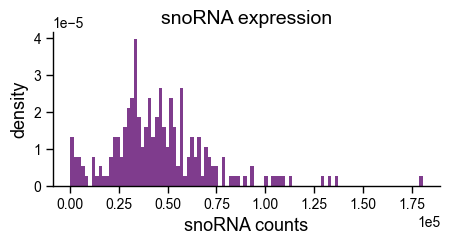

In [23]:
# filter down to any sno "genes" that have nonzero reads in any samples
fig, ax = plt.subplots(1, figsize=(5, 2))

sno_genes = [g for g in gmkf_counts.index if 'SNO' in g]
ax.hist(gmkf_counts.loc[sno_genes].sum(axis=0), bins=100, density=True)
ax.set_xlabel("snoRNA counts")
ax.set_ylabel("density")
sns.despine(ax=ax)
ax.set_title('snoRNA expression')

Some are perhaps a little high, but it's within expectations.

## PCA plot

We use a PCA plot to assess for sample outliers.

In [24]:
norm_matrix = preprocessing.StandardScaler().fit_transform(gmkf_tpms_protein_coding.T)
pca = decomposition.PCA(
    n_components=min(norm_matrix.shape[0] - 1, norm_matrix.shape[1]), random_state=0
)

# transform the data, then store the PC results
pca_transformed_data = pca.fit_transform(norm_matrix)

pca_tpm_df = pd.DataFrame(pca_transformed_data)
pca_tpm_df.columns = ["PC" + str(i) for i in range(1, len(pca_tpm_df.columns) + 1)]
pca_tpm_df.index = gmkf_tpms_protein_coding.columns

pca_tpm_df = pca_tpm_df[['PC1', 'PC2']]

In [25]:
pca_tpm_df.head(2)

,PC1,PC2
sample,,
PT_02SNWVRF,62.790285,-42.123611
PT_0XAWD5CE,0.037953,1.170314


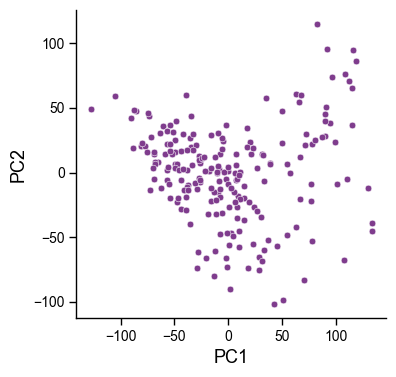

In [26]:
tpm_fig, tpm_ax = plt.subplots(1, figsize=(4, 4))

# plot data
sns.scatterplot(x="PC1", y="PC2", data = pca_tpm_df, ax = tpm_ax)

# reformat figure
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis="both", which="both", length=0)

ax.set_xlabel(
    "PC1: {:.0f}% of variance".format(
        pca.explained_variance_ratio_[0] * 100
    )
)
ax.set_ylabel(
    "PC2: {:.0f}% of variance".format(
        pca.explained_variance_ratio_[1] * 100
    )
)

sns.despine(ax = tpm_ax, bottom=False, left=False)

There at least doesn't seem to be a huge cluster of samples separated from others.

## House keeping genes

Another metric we can use is the count of house-keeping genes. If a subset of samples are much higher or lower than others in housekeeping genes, it may indicate a sample issue.

In [27]:
housekeeping = ["ACTB", "GAPDH", "TBP", "UBC", "RPS18"]
housekeeping_counts = (
    gmkf_counts.loc[housekeeping]
)
housekeeping_counts_norm = stats.zscore(housekeeping_counts, axis=1)

In [28]:
housekeeping_counts_norm.head(2)

sample,PT_02SNWVRF,PT_0XAWD5CE,PT_10KTTTPD,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1MWZEHCT,PT_1NDSW1JX,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_1YAJEAMJ,PT_21PJ8R0Z,PT_22BQQFYM,PT_26E4RFYV,PT_2AZNEYG9,PT_2DX56CE0,PT_2FB9C15K,PT_2G290D0G,PT_2HCWZNTR,PT_2JZNQGTR,PT_2M970JK9,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_2YBKT6RW,PT_3VNMNFT6,PT_3WF5J3PZ,PT_3YW2V4JK,PT_49FZV0HC,PT_4A1B95TK,PT_4FTZAAC4,PT_4W8PD8TR,PT_4WVGKQRX,PT_4Y3P2N1P,PT_53M7K3JE,PT_56ZM694R,PT_581CW7RN,PT_58J0PB4V,PT_5CPS8GNT,PT_5E269C8Z,PT_5FCYBT0S,PT_5MA1YQ49,PT_5W51TAZS,PT_64B8K70Y,PT_66Y5KGME,PT_69AGBVQ5,PT_69EVASRX,PT_6DHGCDRP,PT_6HZH56MX,PT_6M0TPG4X,PT_6R3RJ6MY,PT_6TM0T48Z,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_7XV9SBKQ,PT_81RSHW1D,PT_82D2FJV2,PT_86NG4W76,PT_89D6BFGP,PT_8BYCCC0V,PT_8DFBAQVQ,PT_8HFHWZH9,PT_8RQQWAQR,PT_92RR9C8D,PT_9A9Q2YB3,PT_9DD8F0VD,PT_9GRB7EF0,PT_9K8VF0Z0,PT_9KB3ESTZ,PT_9NMNEV0Y,PT_9QQ37AWW,PT_9RJY3GWC,PT_9X3MV3GW,PT_A4VM4H5N,PT_A77B7F2F,PT_AGYJR7PZ,PT_APMAKP20,PT_AQS8CCAB,PT_ASH4P45D,PT_ASJZTDRF,PT_ATQMV6B3,PT_B0YZ0H85,PT_B39849MF,PT_B9CP3H35,PT_B9X3H54Y,PT_BZCXTAH9,PT_BZZY1BM4,PT_C32MGZSB,PT_C3YC0C9Q,PT_C6429DZZ,PT_CCC65GCE,PT_CV0FE3Z3,PT_D4SZQV48,PT_D508JGWE,PT_D5BYDHZ9,PT_D9XF79J4,PT_DCBZYQAX,PT_DP679T4D,PT_DS5XN67S,PT_E3R0MRXN,PT_E6CZS2KF,PT_E7PFZT6E,PT_ECTDZ6QS,PT_EKP4F49T,PT_ESKA5P5B,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FW0K9SXK,PT_FZ3XEWEK,PT_G3Q35987,PT_GGJ9E0VV,PT_GQBEY0JD,PT_GSWXPFPQ,PT_GV2XJJTP,PT_H2Q0BW73,PT_H3GBG09Q,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HC1QFR28,PT_HQ23GQ23,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_HZQ6TWR9,PT_J3X9NQ5F,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K5709E5B,PT_K579G3KQ,PT_K59VNJ70,PT_KBT22K39,PT_KBVX8B37,PT_KH0H9EZS,PT_KRHMQFFP,PT_KWEJJM22,PT_KWRFGRER,PT_KX5R6KSM,PT_KXWQXAR4,PT_M4ETZ912,PT_M6QAJFS8,PT_M8RHAK5K,PT_MG3HP8D9,PT_MK375DCF,PT_NK39AFPG,PT_NYMKWAZT,PT_NZ3F3J67,PT_P111JVHP,PT_P2M0Q2KS,PT_P7V330C5,PT_P9QJMTF8,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QCMS0C3W,PT_QF2A2F08,PT_QH23VVKW,PT_QW5Q0G84,PT_QZFYXPJK,PT_R07QYFJ0,PT_R94DDN50,PT_RG7MMHFF,PT_RJPEMEQV,PT_RMH6RJ1P,PT_RS3TBZV5,PT_RSPKGFXS,PT_RVTVP55V,PT_S4EJKTME,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V1HR5C5P,PT_V3BXBVVV,PT_V65ESGCE,PT_VA8GM98Z,PT_VVVS471N,PT_W6AVZF18,PT_WG51EA8V,PT_WH6RANZQ,PT_WSQ011Z1,PT_WWQGABFP,PT_WWRAC6EH,PT_X8N7GE8X,PT_XDPN4357,PT_XKZYFJZV,PT_XNBJNRXJ,PT_XNDPC9TT,PT_XPGEBQKA,PT_XPTE7785,PT_YGW6KQHQ,PT_YHWENHB0,PT_YJ8KZG27,PT_YMDFCE4V,PT_YPK89ADE,PT_YS31MFW0,PT_YYGH8EMR,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZS5D8MVF,PT_ZT2NW6WA,PT_ZW22K0YF
gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACTB,0.122331,-0.765518,0.327397,1.928226,-0.153623,-0.748021,1.191358,0.713033,1.156279,-0.675784,-0.736558,1.234719,0.324286,-0.578615,-0.419048,-0.202749,-1.738698,-0.519291,-1.629634,0.291364,0.197110,0.229384,2.732868,1.340938,-1.307591,-0.665794,-0.691276,-0.503405,-1.418483,-0.872605,0.869875,0.968843,-1.123332,-0.406113,2.314742,0.967317,-0.063082,-0.186298,-0.605089,-1.673864,0.392079,-0.667835,-0.546111,-0.319041,-0.401075,-0.220860,-0.247001,-0.109644,1.437829,0.274326,0.769605,-0.831419,-0.204828,3.439282,0.912320,0.156034,0.216931,-0.704652,1.101330,0.715006,-0.244259,-0.351008,0.964824,0.118909,-0.058539,-0.075745,1.307634,0.170241,-0.674170,0.449634,0.054308,-0.733071,-0.738264,-0.566577,-0.218210,-0.073524,-0.018616,-0.353294,-0.101474,-0.516993,2.070261,-0.545409,-0.420364,0.603188,0.323974,-0.085574,-1.054629,-0.762808,-0.149151,-1.21146,-0.162155,-1.036797,0.095135,-0.026245,-0.105297,0.256900,1.108611,-0.073601,-0.769086,0.429664,0.380156,2.437190,-0.139571,-0.322063,-0.382710,-0.025095,-1.291054,-0.896570,-0.121220,0.361053,0.675948,0.502522,0.317380,-0.104994,-0.238768,2.938825,-1.637976,2.573060,-0.503358,0.754198,0.627997,-1.052467,4.126692,0.409473,-0.121647,1.745979,-0.59483,-0.262512,-0.305508,-0.534117,-1.094631,-0.1

Let's plot these on a heatmap

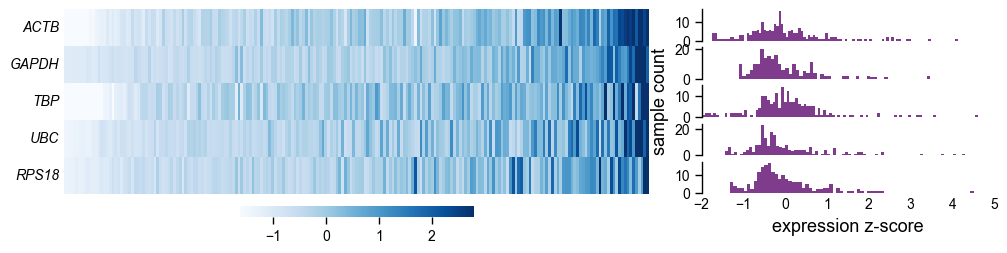

In [29]:
# define a rough order
sample_order = housekeeping_counts_norm.mean(axis=0).sort_values().index

# make the figure and gridspec
fig = plt.figure(figsize=(12, 3))
gs = fig.add_gridspec(5, 2, width_ratios=[2, 1], wspace=0.12)

# plot the heatmap
heatmap_ax = fig.add_subplot(gs[:, 0])

sns.heatmap(
    housekeeping_counts_norm.loc[:, sample_order],
    cmap="Blues",
    robust=True,
    ax=heatmap_ax,
    cbar_kws={"orientation": "horizontal", "pad": 0.05, "shrink": 0.4},
)
heatmap_ax.set_yticklabels(housekeeping, rotation=0, ha="right", fontstyle="italic")
heatmap_ax.tick_params(which="both", length=0)
heatmap_ax.set_xticklabels([])
heatmap_ax.set_ylabel("")
heatmap_ax.set_xlabel("")

gene_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(
    6, 1, gs[:, 1], height_ratios=[1] * 5 + [1.3]
)
for i, g in enumerate(housekeeping):
    ax = fig.add_subplot(gene_gs[i])
    ax.hist(housekeeping_counts_norm.loc[g, :], bins=100)
    sns.despine(ax=ax, bottom=True)
    ax.set_xlim([-2, 5])
    if i != 4:
        ax.get_xaxis().set_visible(False)

    else:
        ax.tick_params(axis="x", length=0)
        ax.set_xlabel("expression z-score")

    if i == 2:
        ax.set_ylabel("sample count")

# fig.savefig("images/cwas/housekeeping-expression.png", bbox_inches="tight")

There is a range of expression of the housekeeping genes, but it does not seem especially dramatic (it's also not clear to me that filtering based on these metrics is sound, in any case).

We can examine these samples on our PCA plot:

In [30]:
housekeeping_mean = housekeeping_counts_norm.mean(axis=0)

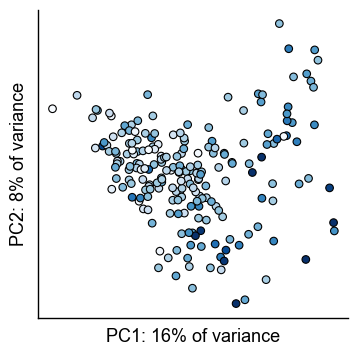

In [31]:
tpm_fig, tpm_axes = plt.subplots(1, figsize=(4, 4))

norm = matplotlib.colors.Normalize(vmin=-1.5, vmax=2)

data = pca_tpm_df[["PC1", "PC2"]].copy()

# add in housekeeping data
data["housekeeping"] = housekeeping_mean.loc[data.index]

# plot data
points = tpm_axes.scatter(
    data["PC1"],
    data["PC2"],
    c=data["housekeeping"],
    cmap=plt.get_cmap("Blues"),
    norm=norm,
    edgecolor="black",
    s=30,
)

tpm_axes.set_xticklabels([])
tpm_axes.set_yticklabels([])
tpm_axes.tick_params(axis="both", which="both", length=0)

tpm_axes.set_xlabel(
    "PC1: {:.0f}% of variance".format(
        pca.explained_variance_ratio_[0] * 100
    )
)
tpm_axes.set_ylabel(
    "PC2: {:.0f}% of variance".format(
        pca.explained_variance_ratio_[1] * 100
    )
)

sns.despine(bottom=False, left=False)

It does not seem like there is a strong association between housekeeping gene expression and outlier status, so we will not filter based on this metric.